In [1]:
import numpy as np
import pandas as pd
from netpixi.integration.gt import *
from regression.integration.gt import *
import math
from graph_tool import centrality, clustering
import regression as reg
from model import Model, data_dir, file_save_name

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1583: PendingDeprecationWarning: The register_cmap function will b

In [2]:
dir_ = 'votacao/'
data_file_name = 'camara_municipal_sp_sessoes_12_20.csv'
name_file_name = 'nomes.csv'

data_file_dir = dir_ + data_file_name
name_file_dir = dir_ + name_file_name

In [3]:
df = pd.read_csv(data_file_dir)
nm = pd.read_csv(name_file_dir)
centros = ['PTB', 'PP', 'PPS', 'PDT', 'PV', 'PSB', 'PHS', 'MDB', 'REDE', 'CIDADANIA', 'S/PARTIDO']

In [4]:
# # Descomentar apenas se Model mudar
# x = Model(df, nm, centros, 2013, 2016)
# y = Model(df, nm, centros, 2017, 2020)
z = Model(df, nm, centros)

In [5]:
# # Descomentar apenas se Model mudar
# x.do_all()
# y.do_all()
z.do_all()

In [15]:
rec_13_16 = pd.read_csv(data_dir + file_save_name + "_" + str(2013) + "_" + str(2016) + ".csv")
rec_17_20 = pd.read_csv(data_dir + file_save_name + "_" + str(2017) + "_" + str(2020) + ".csv")
rec_all = pd.read_csv(data_dir + file_save_name + "_" + str(2013) + "_" + str(2020) + ".csv")

In [16]:
rec_13_16.drop(columns='Unnamed: 0', axis=1)

,id,betweenness,clustering,parlamentares,partido,extreme_party,success,gender
0,132,0.002700,0.901596,0.027027,PP,0,0.902174,0
1,155,0.005679,0.850679,0.175676,PT,1,0.896406,0
2,176,0.000516,0.896667,0.094595,PV,0,0.873239,0
3,179,0.002017,0.926263,0.027027,PDT,0,0.914062,0
4,187,0.004122,0.911111,0.148649,PSDB,1,0.497908,0
...,...,...,...,...,...,...,...,...
69,2108,0.017473,0.855180,0.094595,PV,0,0.921569,0
70,2127,0.004801,0.873227,0.081081,PTB,0,0.906367,0
71,2129,0.003053,0.896277,0.027027,DEMOCRATAS,1,0.906977,0
72,2131,0.003702,0.886179,0.027027,PHS,0,0.815789,0


In [17]:
rec_17_20.drop(columns='Unnamed: 0', axis=1)

,id,betweenness,clustering,parlamentares,partido,extreme_party,success,gender
0,155,0.000073,0.981818,0.147059,PT,1,0.588235,0
1,160,0.002306,0.858974,0.147059,PT,1,0.555556,0
2,187,0.003156,0.904348,0.191176,PSDB,1,0.940845,0
3,220,0.005550,0.875116,0.058824,PR,1,0.924188,0
4,224,0.002885,0.914141,0.191176,PSDB,1,0.915942,0
...,...,...,...,...,...,...,...,...
63,2174,0.052702,0.560440,0.029412,PSC,1,0.717949,0
64,2180,0.000000,1.000000,0.147059,PT,1,0.333333,0
65,2185,0.051025,0.772727,0.058824,PSOL,1,0.532787,0
66,2186,0.003584,0.915854,0.191176,PSDB,1,0.982143,0


In [18]:
rec_all.drop(columns='Unnamed: 0', axis=1)

,id,betweenness,clustering,parlamentares,partido,extreme_party,success,gender
0,132,0.000731,0.918519,0.019417,PP,0,0.902174,0
1,155,0.006360,0.801093,0.145631,PT,1,0.834459,0
2,160,0.001752,0.717949,0.145631,PT,1,0.555556,0
3,176,0.000242,0.958372,0.077670,PV,0,0.873239,0
4,179,0.000259,0.957447,0.019417,PDT,0,0.914062,0
...,...,...,...,...,...,...,...,...
98,2174,0.003064,0.685714,0.019417,PSC,1,0.717949,0
99,2180,0.000134,0.600000,0.145631,PT,1,0.333333,0
100,2185,0.001979,0.571429,0.038835,PSOL,1,0.532787,0
101,2186,0.001394,0.866002,0.165049,PSDB,1,0.982143,0


In [19]:
reg_clu__rep_2013_2016 = reg.linear(data=rec_13_16, formula='clustering ~ parlamentares + gender')
reg_bet__rep_2013_2016 = reg.linear(data=rec_13_16, formula='betweenness ~ parlamentares')
reg_clu__ep_2013_2016 = reg.linear(data=rec_13_16, formula='clustering ~ extreme_party + gender')
reg_clu__rep_ep_2013_2016 = reg.linear(data=rec_13_16, formula='clustering ~ parlamentares + extreme_party + gender')
display(reg_clu__rep_2013_2016.micro_summary())
display(reg_bet__rep_2013_2016.micro_summary())
display(reg_clu__ep_2013_2016.micro_summary())
display(reg_clu__rep_ep_2013_2016.micro_summary())

variable,coefficient,std error,p-value
parlamentares,0.703954,0.421104,0.098988
gender,0.059151,0.076098,0.439562


variable,coefficient,std error,p-value
parlamentares,0.073364,0.082388,0.376180


variable,coefficient,std error,p-value
extreme_party,-0.014131,0.053586,0.792768
gender,0.073378,0.077801,0.348802


variable,coefficient,std error,p-value
parlamentares,0.842070,0.448983,0.064894
extreme_party,-0.050236,0.056069,0.373342
gender,0.065797,0.076564,0.393068


In [20]:
reg_clu__rep_2017_2020 = reg.linear(data=rec_17_20, formula='clustering ~ parlamentares + gender')
reg_bet__rep_2017_2020 = reg.linear(data=rec_17_20, formula='betweenness ~ parlamentares')
reg_clu__ep_2017_2020 = reg.linear(data=rec_17_20, formula='clustering ~ extreme_party + gender')
reg_clu__rep_ep_2017_2020 = reg.linear(data=rec_17_20, formula='clustering ~ parlamentares + extreme_party + gender')
display(reg_clu__rep_2017_2020.micro_summary())
display(reg_bet__rep_2017_2020.micro_summary())
display(reg_clu__ep_2017_2020.micro_summary())
display(reg_clu__rep_ep_2017_2020.micro_summary())

variable,coefficient,std error,p-value
parlamentares,0.580538,0.336259,0.089015
gender,0.046385,0.055608,0.407257


variable,coefficient,std error,p-value
parlamentares,-0.019842,0.048902,0.686237


variable,coefficient,std error,p-value
extreme_party,0.004053,0.051503,0.937520
gender,0.056309,0.057307,0.329458


variable,coefficient,std error,p-value
parlamentares,0.717294,0.378898,0.062867
extreme_party,-0.044927,0.056750,0.431477
gender,0.052161,0.056244,0.357196


In [33]:
np.sort(rec_all['clustering'])

array([0.        , 0.        , 0.33333333, 0.50980392, 0.52380952,
       0.56884058, 0.57142857, 0.58088235, 0.6       , 0.62251984,
       0.64484127, 0.65061728, 0.65943993, 0.65943993, 0.66237425,
       0.66330114, 0.66512346, 0.6654321 , 0.66601753, 0.66666667,
       0.66820988, 0.67098765, 0.67098765, 0.67098765, 0.67098765,
       0.67232767, 0.67478092, 0.6754386 , 0.67689873, 0.68571429,
       0.68614086, 0.69390244, 0.69559033, 0.69875223, 0.70827286,
       0.71269841, 0.71596639, 0.71794872, 0.72727273, 0.73903211,
       0.7486631 , 0.76503497, 0.77322404, 0.77578001, 0.78001058,
       0.78021978, 0.78787879, 0.79602572, 0.79719462, 0.8       ,
       0.8010929 , 0.80714286, 0.82312925, 0.82760943, 0.83183673,
       0.84081633, 0.84081633, 0.85283688, 0.85289116, 0.85289116,
       0.8537415 , 0.85904255, 0.85946574, 0.85984848, 0.86394558,
       0.86394558, 0.86600221, 0.86932849, 0.8700565 , 0.8700565 ,
       0.87272727, 0.87677305, 0.87677305, 0.87677305, 0.87677

In [41]:
reg_clu__rep_all = reg.linear(data=rec_all, formula='clustering ~ parlamentares + gender')
reg_bet__rep_all = reg.linear(data=rec_all, formula='betweenness ~ parlamentares')
reg_clu__ep_all = reg.linear(data=rec_all, formula='clustering ~ extreme_party + gender')
reg_clu__rep_ep_all = reg.linear(data=rec_all, formula='clustering ~ parlamentares + extreme_party + gender')
display(reg_clu__rep_all.micro_summary())
display(reg_bet__rep_all.micro_summary())
display(reg_clu__ep_all.micro_summary())
display(reg_clu__rep_ep_all.micro_summary())

variable,coefficient,std error,p-value
parlamentares,0.408435,0.294430,0.168463
gender,-0.023951,0.046736,0.609448


variable,coefficient,std error,p-value
parlamentares,-0.003904,0.009550,0.683520


variable,coefficient,std error,p-value
extreme_party,-0.035506,0.038231,0.355269
gender,-0.013003,0.047082,0.782989


variable,coefficient,std error,p-value
parlamentares,0.583115,0.313442,0.065803
extreme_party,-0.062638,0.040487,0.125028
gender,-0.017786,0.046585,0.703435


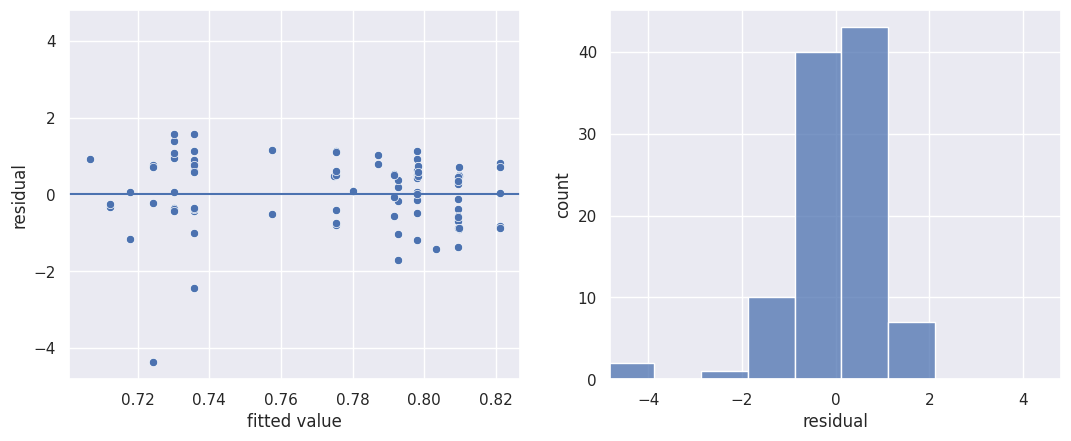

In [42]:
reg_clu__rep_ep_all.plot_residuals()

<AxesSubplot: ylabel='Frequency'>

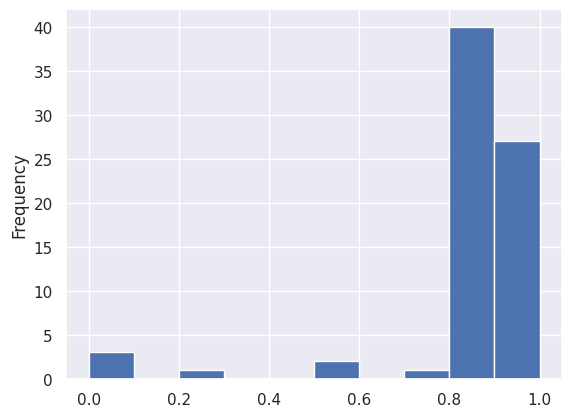

In [40]:
reg_clu__rep_ep_all.plot_residuals(rec_all[''])